### Todo
* Add geographical repartition (cartogramm) heatmap by %age of parrainage by candidate by region
* Does the "parrain" respect his own political color ?
* Geographical diversity
* Quel département soutient quel candidat ?

# Sources
* Autre projet : Le Monde 20220222 : https://www.lemonde.fr/les-decodeurs/article/2022/02/01/election-presidentielle-2022-visualisez-les-parrainages-obtenus-par-les-candidats_6111902_4355770.html
* Population : INSEE 20220222 : https://www.insee.fr/fr/statistiques/4277602?sommaire=4318291#consulter
* Couleur politique : Le Monde 20220222 : https://www.lemonde.fr/les-decodeurs/article/2021/06/02/presidentielle-2022-qui-sont-les-candidats-declares-et-pressentis_6082545_4355770.html
* Coulmont : https://twitter.com/coulmont
* Le Monde : https://www.lemonde.fr/les-decodeurs/article/2022/02/22/presidentielle-2022-le-tableau-de-bord-des-parrainages-sondages-et-temps-de-parole_6114816_4355770.html
* France Télévision : https://www.francetvinfo.fr/elections/presidentielle/candidats/presidentielle-pourquoi-la-limite-de-50-parrainages-par-departement-pourrait-creer-des-surprises_4977189.html#xtor=CS2-765-%5Bautres%5D-
* Répertoire national des élus (RNE) : https://www.data.gouv.fr/fr/datasets/repertoire-national-des-elus-1/

In [1]:
import contextily as ctx
from datetime import date, datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

DATA_URL = 'https://presidentielle2022.conseil-constitutionnel.fr/telechargement/parrainagestotal.json'
DATA_FOLDER = 'data'
DATA_FILE = 'parrainagestotal-20220224.json'
RESULTS_FOLDER = 'results'
SOURCE_FOLDER = 'sources'
THRESHOLD = 500

plt.rcParams['figure.figsize'] = [9, 11]

In [2]:
# 1. Save today's file
#response = requests.get(DATA_URL).json()
#data = pd.json_normalize(response)
#today = date.today().strftime('%Y%m%d')
#filename = f'parrainagestotal-{today}.json'
#data.to_json(f'{DATA_FOLDER}/{filename}', orient='records', indent=2, force_ascii=False)

In [3]:
female_color = '#FC363B'
male_color = '#2766F6'
candidates = {
    'PÉCRESSE Valérie': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#419BF9'
    },
    'MACRON Emmanuel': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#FEA419'
    },
    'HIDALGO Anne': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#F76083'
    },
    'ROUSSEL Fabien': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#DB304F'
    },
    'JADOT Yannick': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#31A31A'
    },
    'LASSALLE Jean': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#AF48B2'
    },
    'ARTHAUD Nathalie': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#BA0523'
    },
    'MÉLENCHON Jean-Luc': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#DB304F'
    },
    'DUPONT-AIGNAN Nicolas': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#7A4724'
    },
    'LE PEN Marine': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#7A4724'
    },
    'ZEMMOUR Éric': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#7A4724'
    },
    'ASSELINEAU François': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#AF48B2'
    },
    'POUTOU Philippe': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#BA0523'
    },
    'KAZIB Anasse': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#BA0523'
    },
    'TAUBIRA Christiane': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#F76083'
    },
    'THOUY Hélène': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#AF48B2'
    }
}

# 2. Load all data
sponsorships = pd.read_json(os.path.join(DATA_FOLDER, DATA_FILE))

# Transform
## Rename columns
columns = {
    'Mandat': 'mandat'
}
sponsorships = sponsorships.rename(columns=columns)
## Number of sponsorships
total_sponsorships = len(sponsorships)
## Gender
genders_by_civility = {
    'M.': 'male',
    'Mme': 'female'
}
sponsorships['gender_calculated'] = sponsorships['Civilite'].apply(lambda x: genders_by_civility.get(x, 'unknown'))
## Mandate
mandates = {
    "Conseiller de Paris": "Conseiller de Paris",
    "Conseiller départemental": "Conseiller départemental",
    "Conseiller métropolitain de Lyon": "Conseiller métropolitain de Lyon",
    "Conseiller régional": "Conseiller régional",
    "Conseiller à l'Assemblée des Français de l'étranger": "Conseiller à l'Assemblée des Français de l'étranger",
    "Conseillère de Paris": "Conseiller de Paris",
    "Conseillère départementale": "Conseiller départemental",
    "Conseillère métropolitaine de Lyon": "Conseiller métropolitain de Lyon",
    "Conseillère régionale": "Conseiller régional",
    "Conseillère à l'Assemblée des Français de l'étranger": "Conseiller à l'Assemblée des Français de l'étranger",
    "Député": "Député",
    "Députée": "Député",
    "Maire": "Maire",
    "Maire d'arrondissement": "Maire d'arrondissement",
    "Maire délégué d'une commune associée ou d'une commune déléguée": "Maire délégué d'une commune associée ou d'une commune déléguée",
    "Maire déléguée d'une commune associée ou d'une commune déléguée": "Maire délégué d'une commune associée ou d'une commune déléguée",
    "Membre d'une assemblée d'une collectivité territoriale d'outre-mer à statut particulier": "Membre d'une assemblée d'une collectivité territoriale d'outre-mer à statut particulier",
    "Membre de l'Assemblée de Corse": "Membre de l'Assemblée de Corse",
    "Président d'un EPCI à fiscalité propre": "Président d'un EPCI à fiscalité propre",
    "Président du conseil consulaire": "Président du conseil consulaire",
    "Présidente d'un EPCI à fiscalité propre": "Président d'un EPCI à fiscalité propre",
    "Présidente du conseil consulaire": "Président du conseil consulaire",
    "Représentant français au Parlement européen": "Représentant français au Parlement européen",
    "Représentante française au Parlement européen": "Représentant français au Parlement européen",
    "Sénateur": "Sénateur",
    "Sénatrice": "Sénateur"
}
sponsorships['mandat_calculated'] = sponsorships['mandat'].apply(lambda x: mandates.get(x, 'unknown'))
## Population by city
cities = pd.read_csv(os.path.join(SOURCE_FOLDER, 'communes.csv'), sep=';').get(['COM', 'PTOT']).set_index('COM').to_dict()['PTOT']
sponsorships['population_calculated'] = sponsorships['Circonscription'].apply(lambda x: cities.get(x, 0))
## DatePublication
sponsorships['DatePublication'] = sponsorships['DatePublication'].apply(lambda x: x.replace('T00:00:00', ''))

sponsorships

,Civilite,Nom,Prenom,mandat,Circonscription,Departement,Candidat,DatePublication,gender_calculated,mandat_calculated,population_calculated
0,M.,CORDIVAL,Gilles,Maire,Mont-Saint-Père,Aisne,ARTHAUD Nathalie,2022-02-01,male,Maire,709
1,Mme,VALLIET,Odile,Maire,Crupilly,Aisne,ARTHAUD Nathalie,2022-02-01,female,Maire,66
2,M.,GUEYRAUD,Jean-Marie,Maire,Saint-Auban-d'Oze,Hautes-Alpes,ARTHAUD Nathalie,2022-02-01,male,Maire,85
3,Mme,NOUVEL,Marie-Claude,Maire,Seignalens,Aude,ARTHAUD Nathalie,2022-02-01,female,Maire,31
4,M.,GAINCHE,Jean-Paul,Maire,Langrolay-sur-Rance,Côtes-d'Armor,ARTHAUD Nathalie,2022-02-01,male,Maire,997
...,...,...,...,...,...,...,...,...,...,...,...
10260,M.,LEPATRE,Norbert,Maire,Modène,Vaucluse,ZEMMOUR Éric,2022-02-24,male,Maire,472
10261,M.,SCHIRA,Bruno,Maire,Le Dorat,Haute-Vienne,ZEMMOUR Éric,2022-02-24,male,Maire,1650
10262,M.,TEAGAI,Ernest Igino,Maire,Tatakoto,Polynésie française,ZEMMOUR Éric,2022-02-24,male,Maire,0
10263,M.,CHEVRIER,Christian Henri,Président du conseil consulaire,"Thaïlande, Birmanie",Français de l'étranger,ZEMMOUR Éric,2022-02-24,male,Président du conseil consulaire,0


# Global

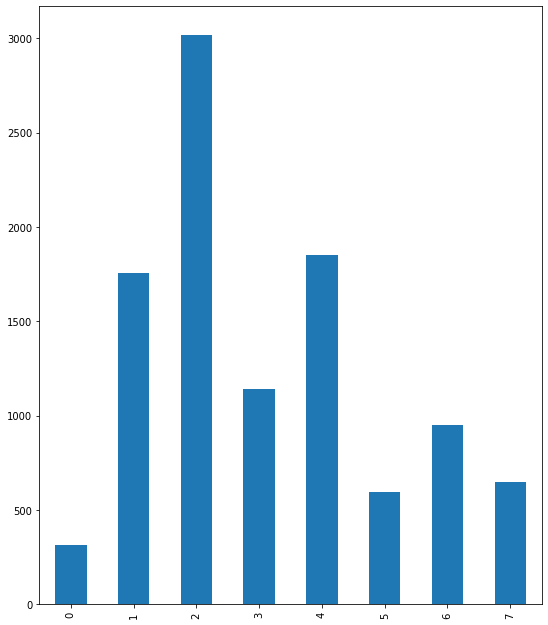

In [4]:
# Number of new sponsorships for each new date
df_count = sponsorships.groupby('DatePublication').count().reset_index().get(['DatePublication', 'Candidat'])
df_count.plot(kind='bar', legend=False)
plt.show()

<Figure size 648x792 with 0 Axes>

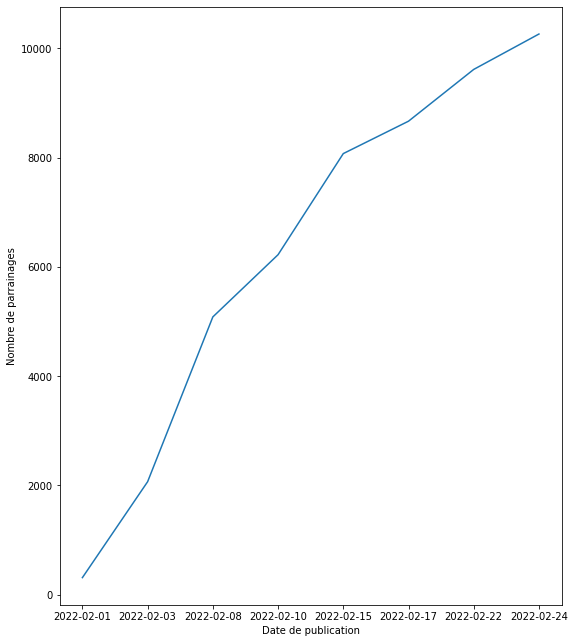

In [5]:
# Number of sponsorships among time
df_count['cumsum'] = df_count['Candidat'].cumsum()
plt.figure(facecolor='yellow')
df_count.plot(x='DatePublication', y='cumsum', legend=False)
plt.xlabel('Date de publication')
plt.ylabel('Nombre de parrainages')
plt.savefig(f'{RESULTS_FOLDER}/sponsorships_by_time.png', facecolor='white', bbox_inches = 'tight')
plt.show()

In [6]:
# List all candidates and their sponsorships count sorted by count descending
df_candidates = sponsorships.groupby('Candidat').count().reset_index().get(['Candidat', 'Civilite']).rename(columns={'Civilite': 'total'}).sort_values('total', ascending=False)
df_candidates

,Candidat,total
36,PÉCRESSE Valérie,2271
25,MACRON Emmanuel,1544
15,HIDALGO Anne,1226
17,JADOT Yannick,615
40,ROUSSEL Fabien,593
22,LASSALLE Jean,579
0,ARTHAUD Nathalie,562
32,MÉLENCHON Jean-Luc,540
10,DUPONT-AIGNAN Nicolas,457
49,ZEMMOUR Éric,415


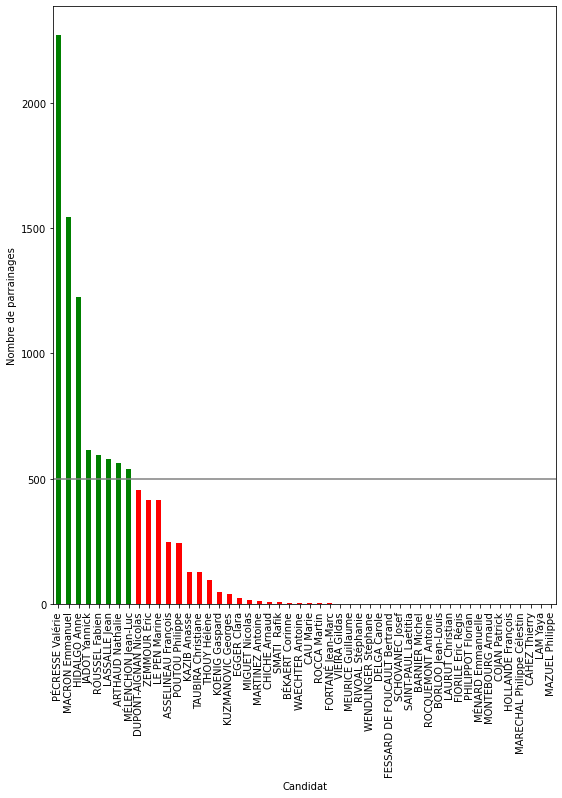

In [7]:
# Number of sponsorships by candidate
axes = df_candidates.plot(x='Candidat', y='total', kind='bar', color=df_candidates['total'].apply(lambda x: 'green' if x >= THRESHOLD else 'red'), legend=False)
axes.axhline(THRESHOLD, color='gray')
plt.xlabel('Candidat')
plt.ylabel('Nombre de parrainages')
plt.savefig(f'{RESULTS_FOLDER}/sponsorships_by_candidate.png', facecolor='white', bbox_inches = 'tight')
plt.show()

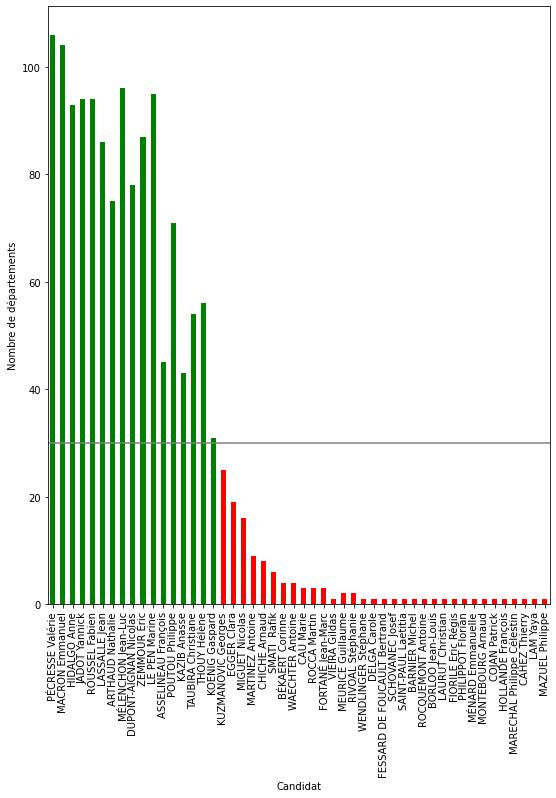

In [8]:
# Number de departments by candidate
department_threshold = 30
df = sponsorships.groupby(['Candidat', 'Departement'])['Candidat'].count().unstack('Departement')#.notna()#.sum(axis=1)
df['total'] = df.sum(axis=1)
df = df.sort_values('total', ascending=False).drop(['total'], axis=1).notna().sum(axis=1)
ax = df.plot(kind='bar', color=df.apply(lambda x: 'green' if x >= department_threshold else 'red'))
ax.axhline(department_threshold, color='gray')
plt.xlabel('Candidat')
plt.ylabel('Nombre de départements')
plt.savefig(f'{RESULTS_FOLDER}/number_of_department_by_candiate.png', facecolor='white', bbox_inches = 'tight')
plt.show()

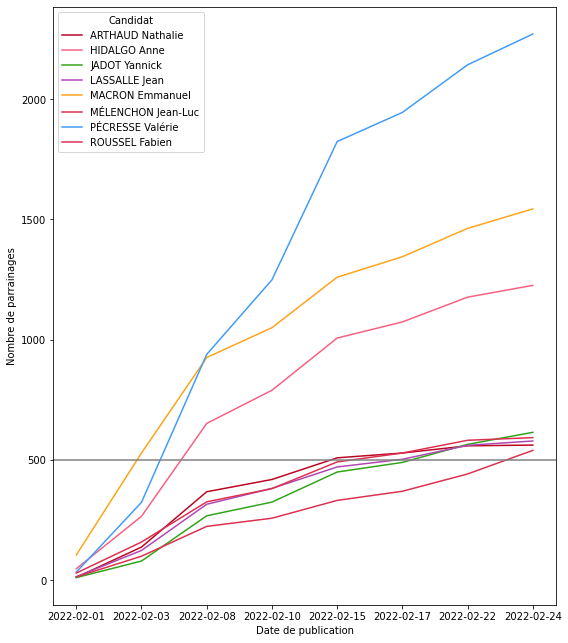

In [9]:
# Number of sponsorships by candidate over the time
df = sponsorships.groupby(['Candidat', 'DatePublication'])['Candidat'].count().unstack('DatePublication').fillna(0).reset_index()
df = df.set_index('Candidat').cumsum(axis=1).query(f'`2022-02-24` > {THRESHOLD}').transpose()
colors = [candidates.get(column, {}).get('political_color', 'black') for column in df.columns]
ax = df.plot(color=colors)
ax.axhline(THRESHOLD, color='gray')
plt.xlabel('Date de publication')
plt.ylabel('Nombre de parrainages')
plt.savefig(f'{RESULTS_FOLDER}/sponsorships_by_candidate_by_time.png', facecolor='white', bbox_inches = 'tight')
plt.show()

# Marrainages

## Global

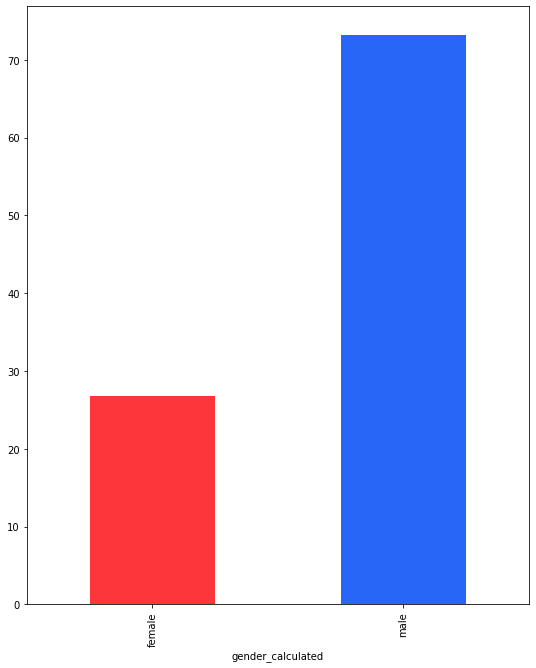

In [10]:
# Sponsorships by gender
df_gender_percent = sponsorships.groupby('gender_calculated').count().reset_index().get(['gender_calculated', 'Candidat']).rename(columns={'Candidat': 'count'})
df_gender_percent['gender_calculated_percent'] = df_gender_percent['count'].apply(lambda x: round(x / total_sponsorships * 100, 2))
df_gender_percent.plot(x='gender_calculated', y='gender_calculated_percent', kind='bar', color=[female_color, male_color], legend=False)
plt.show()

## By candidate

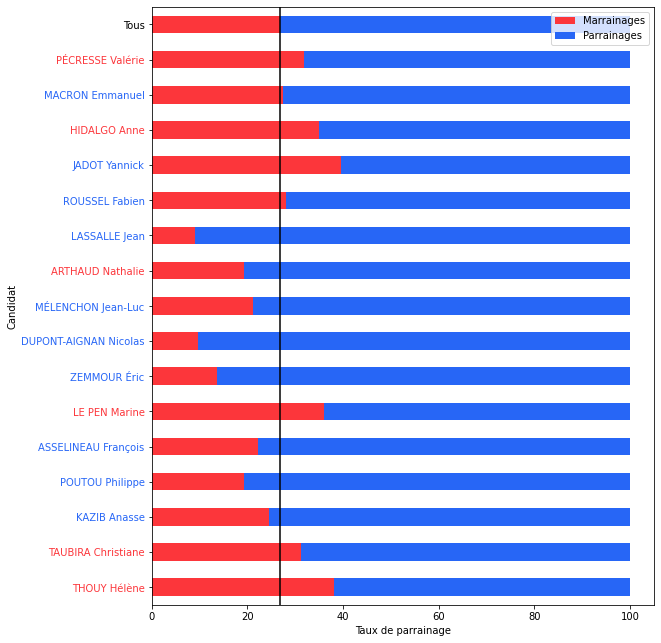

In [11]:
# Sponsorships by gender by candidates
def get_color(tick):
    return candidates.get(tick.get_text(), {}).get('gender_color', 'black')

df = sponsorships.groupby(['Candidat', 'gender_calculated'])['Candidat'].count().unstack('gender_calculated').fillna(0).reset_index()
df['total'] = df.sum(axis=1)
df['female_percent'] = round(df['female'] / df['total'] * 100, 2)
df['male_percent'] = round(df['male'] / df['total'] * 100, 2)
female_calculated_percent = df_gender_percent['gender_calculated_percent'][0]
df.loc[-1] = ['Tous', df_gender_percent['count'][0], df_gender_percent['count'][1], total_sponsorships, female_calculated_percent, df_gender_percent['gender_calculated_percent'][1]]
df.index = df.index + 1
df = df.query('total > 50').sort_values('total').set_index('Candidat').get(['female_percent','male_percent']).rename(columns={'female_percent': 'Marrainages', 'male_percent': 'Parrainages'})
axes = df.plot(kind='barh', stacked=True, color=[female_color, male_color], legend=False)
axes.axvline(female_calculated_percent, color='black')
axes.legend()
[tick.set_color(get_color(tick)) for tick in axes.get_yticklabels()]
plt.xlabel('Taux de parrainage')
plt.ylabel('Candidat')
plt.savefig(f'{RESULTS_FOLDER}/gender_rate_by_candidate.png', facecolor='white', bbox_inches = 'tight')
plt.show()

# Mandat

## Total

In [12]:
sponsorships_mandates = sponsorships.groupby('mandat_calculated').count().rename(columns={'Civilite': 'count'}).sort_values('count', ascending=False)['count']
sponsorships_mandates

mandat_calculated
Maire                                                                                      6513
Conseiller départemental                                                                   1297
Conseiller régional                                                                         941
Député                                                                                      484
Maire délégué d'une commune associée ou d'une commune déléguée                              309
Sénateur                                                                                    259
Conseiller de Paris                                                                         120
Conseiller métropolitain de Lyon                                                             94
Représentant français au Parlement européen                                                  55
Président d'un EPCI à fiscalité propre                                                       54
Conseiller à l'Assembl

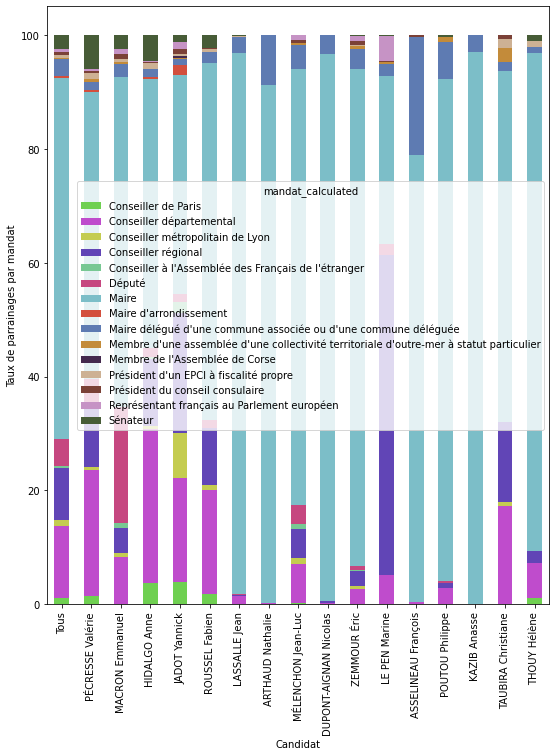

In [13]:
# Sponsorships by mandat by candidat
colors = ['#6FD051', '#BF4CCC', '#C4CC50', '#6145B6', '#78C893', '#C64780', '#7CBEC8', '#D34F3D', '#5E7BB2', '#C38B3A', '#442A4E', '#CDB194', '#7B4137', '#C693C5', '#475C37']
df = sponsorships.groupby(['Candidat', 'mandat_calculated'])['Candidat'].count().unstack('mandat_calculated').fillna(0).reset_index()
# Add a row at first position with national values
all = [sponsorships_mandates[key] for key in df.keys() if key != 'Candidat']
all.insert(0, 'Tous')
df.loc[-1] = all
df.index = df.index + 1
# Add a new column with the sum of sponsorships
df['total'] = df.sum(axis=1)
# Transform each row in percentage of sponsorships
for i, row in df.iterrows():
    for j, value in row.items():
        if j not in ['Candidat', 'total']:
            value_percent = round(value / row['total'] * 100, 2)
            df.at[i, j] = value_percent
df = df.query('total > 50')
df = df.sort_values('total', ascending=False)
df = df.set_index('Candidat')
df.loc[:, df.columns != 'total'].plot(kind='bar', stacked=True, color=colors)
plt.xlabel('Candidat')
plt.ylabel('Taux de parrainages par mandat')
plt.savefig(f'{RESULTS_FOLDER}/mandates_rate_by_candiate.png', facecolor='white', bbox_inches = 'tight')
plt.show()

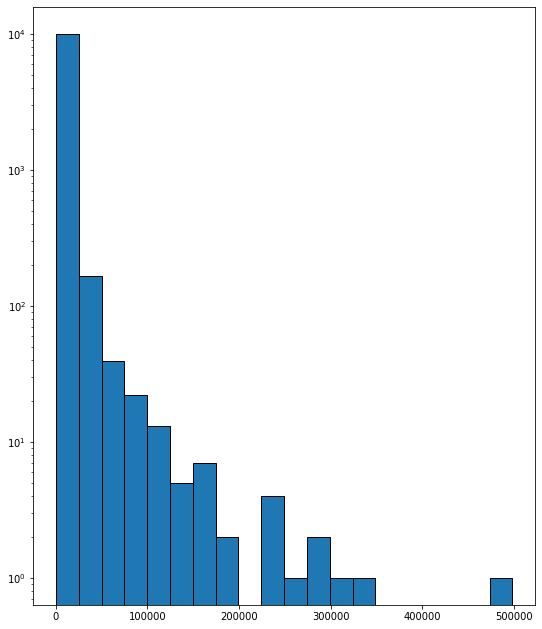

In [14]:
plt.hist(sponsorships['population_calculated'], bins=20, log=True, edgecolor='black')
plt.show()

/home/alhote/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


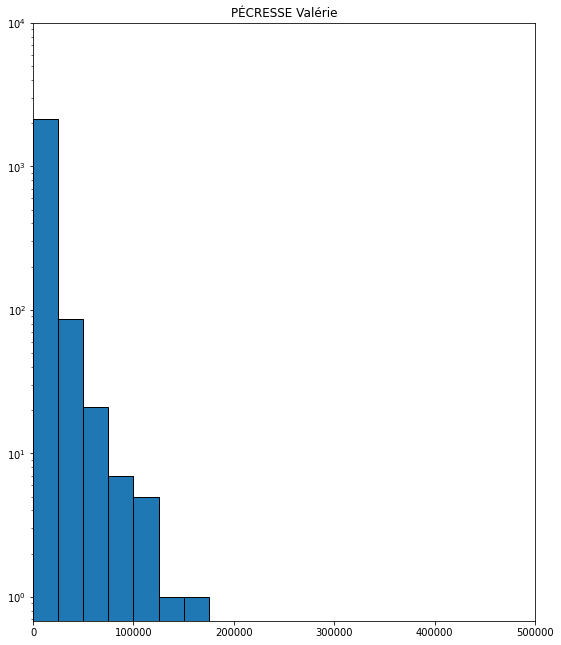

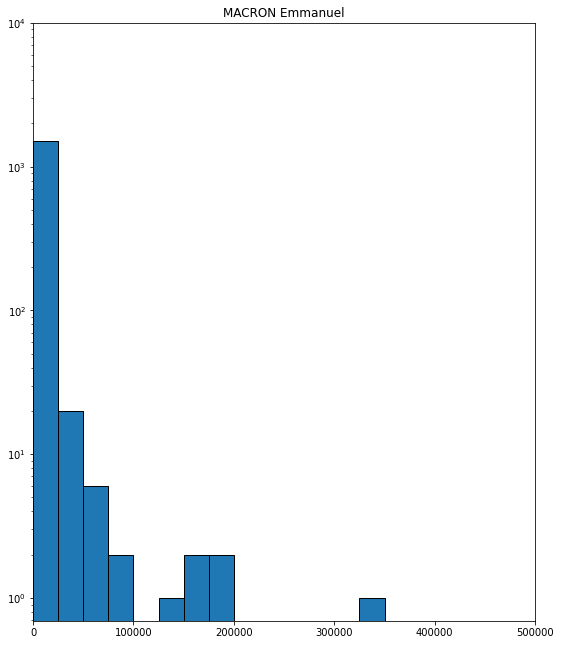

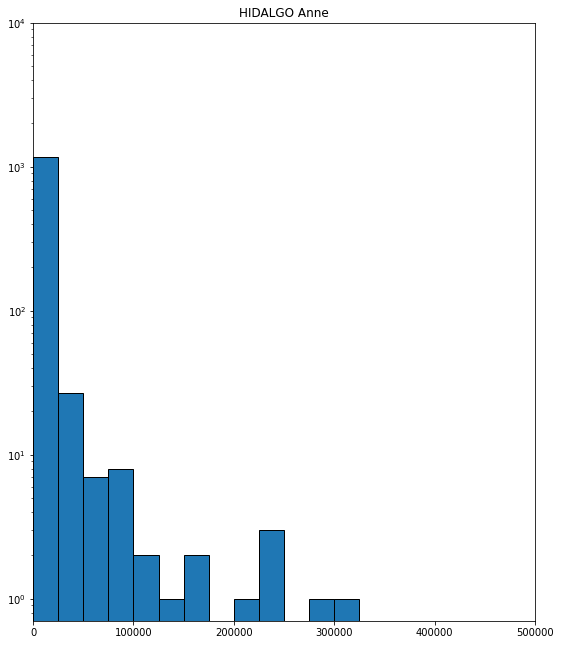

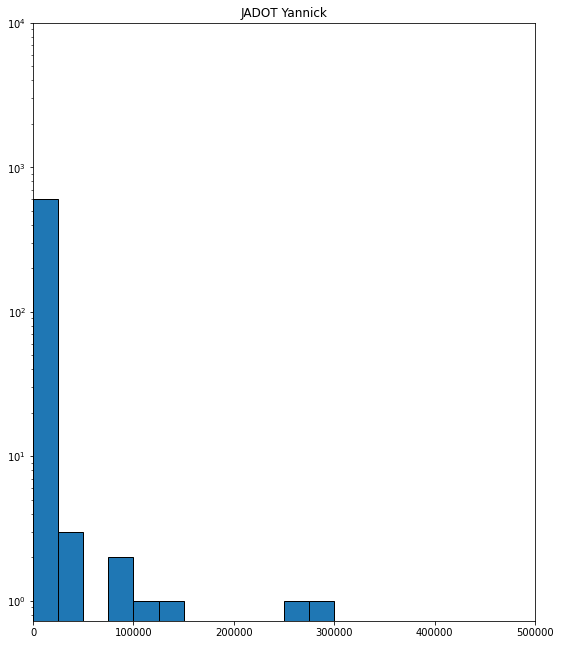

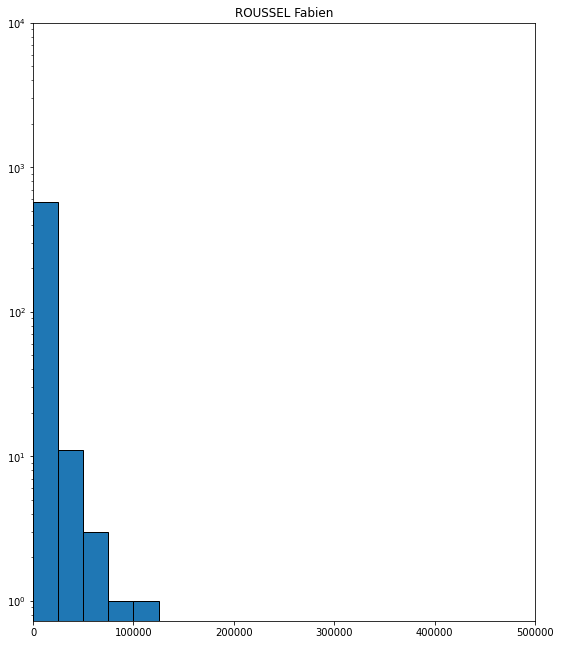

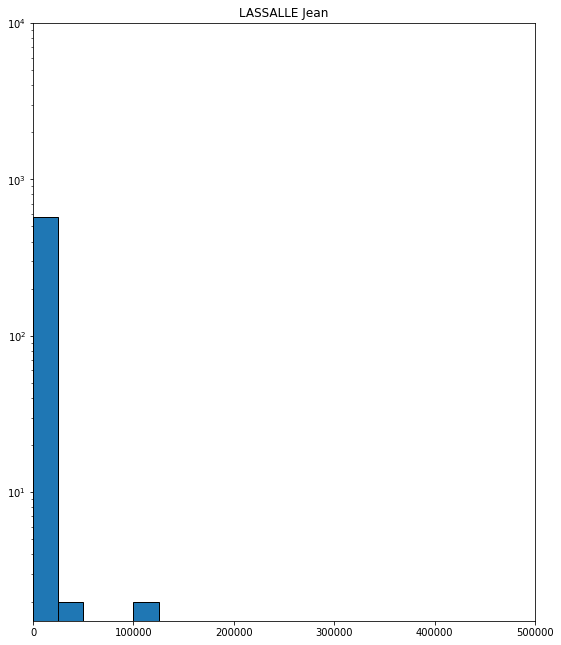

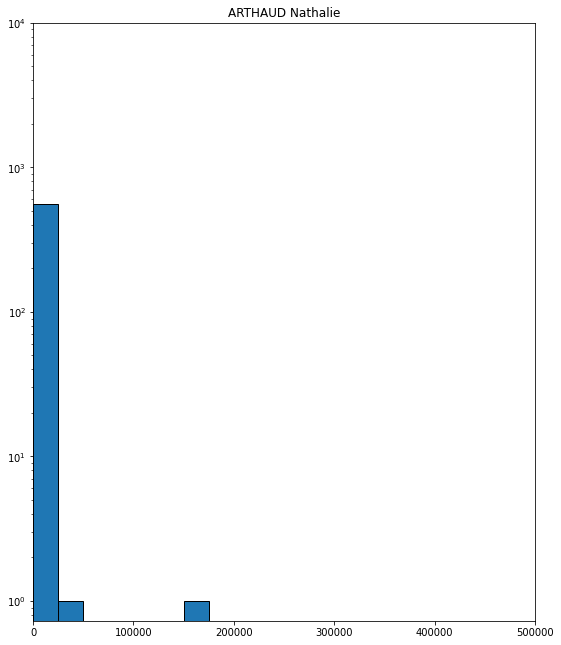

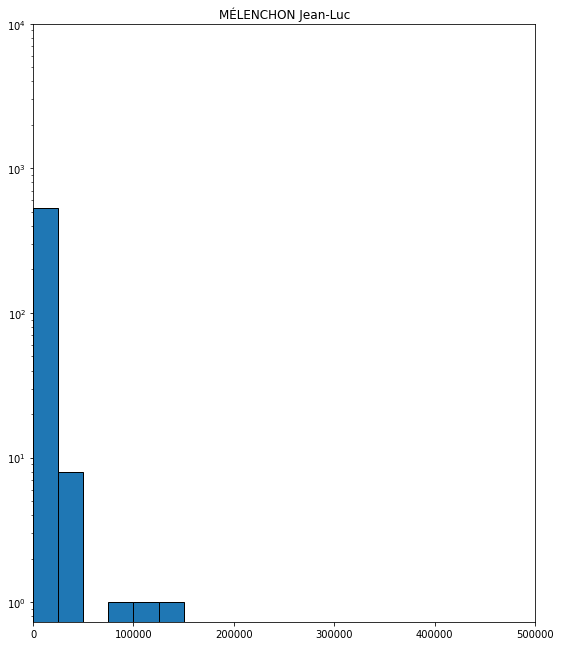

In [15]:
for candidat in df_candidates.query(f'total > {THRESHOLD}')['Candidat']:
    hist = sponsorships.loc[sponsorships['Candidat'] == candidat]
    plt.hist(hist['population_calculated'], bins=range(0, 500000, 25000), log=True, edgecolor='black')
    plt.title(candidat)
    plt.xlim(0, 500000)
    plt.ylim(0, 10000)
    plt.show()

In [16]:
# Heatmap par candidat par département
#communes = gpd.read_file(f'{SOURCE_FOLDER}/communes-20220101.shx')
#communes = communes[~communes.insee.str.startswith(tuple(['97', '98']))]
#communes['values'] = np.abs(np.random.randn(len(communes))) * 50
#communes
#communes.plot(ax=ax, alpha=0.5, edgecolor='blue', markersize=communes['values'])
#ctx.add_basemap(ax, crs = communes.crs.to_string())
#ax.set_axis_off()
#ax
#for _, sponsorship in sponsorships[:5].iterrows():
#    circo = sponsorship.get('Circonscription')
#    tmp = metropole[metropole['nom'] == circo]
#    if len(tmp) > 1:
#        print('There is an error')

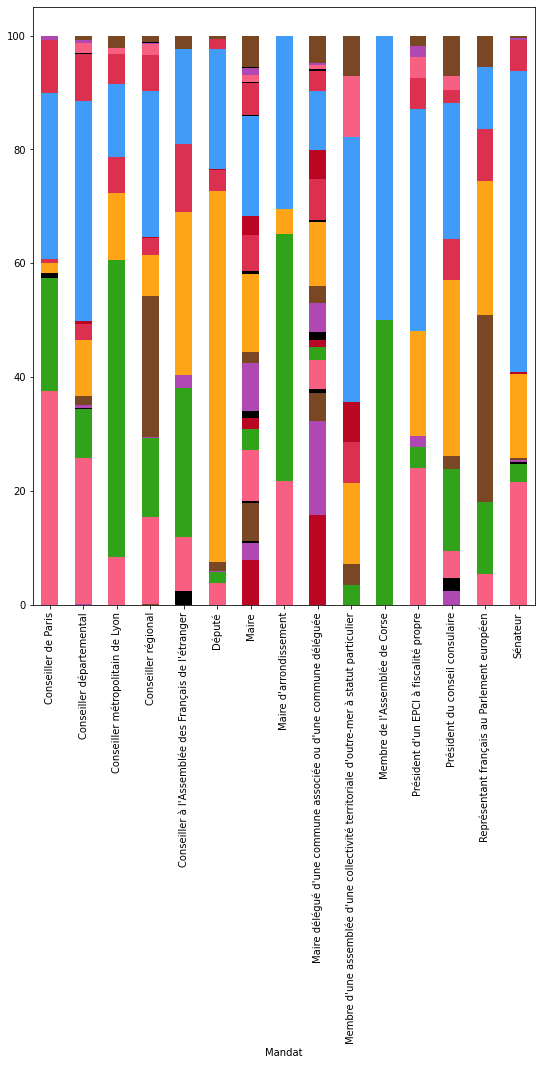

In [17]:
# Quel mandat soutien quel candidat ? (eg. Qui ont parrainé les "Membre de l'Assemblée de Corse" ?)
df = sponsorships.groupby(['mandat_calculated', 'Candidat'])['mandat_calculated'].count().unstack('Candidat').fillna(0)
df['total'] = df.sum(axis=1)
for i, row in df.iterrows():
    for j, item in row.iteritems():
        df[j][i] = df[j][i] / df['total'][i] * 100
colors = [candidates.get(column, {}).get('political_color', 'black') for column in df.columns]
df.loc[:, df.columns != 'total'].plot(kind='bar', stacked=True, color=colors, legend=False)
plt.xlabel('Mandat')
plt.savefig(f'{RESULTS_FOLDER}/candidates_rate_by_mandate.png', facecolor='white', bbox_inches = 'tight')
plt.show()